In [1]:
from keras.utils import np_utils
import matplotlib.pyplot as plt 
from sklearn.datasets import load_files       
import numpy as np
from glob import glob
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
##git difference test

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import tensorflow as tf
import keras

In [4]:
print(tf.__version__)

1.8.0


In [3]:
import os
os.chdir('/home/ubuntu')

In [5]:
batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'autoimages/autov2/img/t1',  # this is the target directory
        target_size=(299,299),  # all images will be resized to 299*299
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'autoimages/autov2/img/v1',
        target_size=(299,299),
        batch_size=batch_size,
        class_mode='categorical')

Found 9741 images belonging to 151 classes.
Found 2149 images belonging to 151 classes.


In [6]:
def get_inception_v3(nb_classes):
    inception = InceptionV3(weights="imagenet", pooling='avg', include_top=False)

    x = inception.output
    x = Dense(1024, activation='relu')(x)  # Why 1024 are not more or less is not clear... Should be tuned if possible
    predictions = Dense(nb_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=inception.input, outputs=predictions)

    return model

In [7]:
# nb_classes = 3849
nb_classes = 151
model = get_inception_v3(nb_classes)

In [8]:
for layer in model.layers[:-20]:
   layer.trainable = False
for layer in model.layers[-20:]:
   layer.trainable = True

In [9]:
from keras import regularizers

In [72]:
model.layers[-20].get_config()

{'name': 'conv2d_180',
 'trainable': True,
 'filters': 320,
 'kernel_size': (1, 1),
 'strides': (1, 1),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': {'class_name': 'L1L2',
  'config': {'l1': 0.0, 'l2': 0.10000000149011612}},
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [10]:
model.layers[-1].kernel_regularizer=regularizers.l2(0.01)

In [11]:
model.layers[-2].kernel_regularizer=regularizers.l2(0.01)

In [12]:
model.layers[-15].kernel_regularizer=regularizers.l2(0.01)

In [13]:
model.layers[-20].kernel_regularizer=regularizers.l2(0.1)

In [28]:
print(model.layers[-1].kernel_regularizer)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16160362656233185412
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7444394804
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12600242262684918883
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(train_generator,
        steps_per_epoch=9741// batch_size,
        epochs=epochs,shuffle=True, 
        validation_data=validation_generator,
        validation_steps=2149// batch_size,
        verbose=1)


Epoch 1/5
304/304 [==============================] - 317s 1s/step - loss: 0.3061 - acc: 0.9080 - val_loss: 4.9349 - val_acc: 0.2729
Epoch 2/5
304/304 [==============================] - 313s 1s/step - loss: 0.3286 - acc: 0.9001 - val_loss: 4.0447 - val_acc: 0.3559
Epoch 3/5
  2/304 [..............................] - ETA: 1:04 - loss: 0.0966 - acc: 0.9688

In [13]:
# model.save('saved_models/weights.best.from_scratch_June18.hdf5')

In [6]:
model.load_weights('saved_models/weights.best.from_scratch_June18.hdf5')

In [11]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import scipy
from matplotlib.pyplot import imshow

Input image shape: (1, 299, 299, 3)
class prediction vector [p(0), p(1), ..., p(100)] = 
[23]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


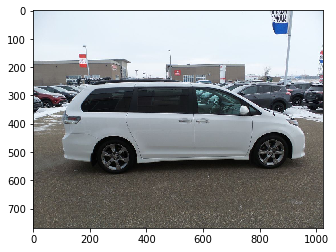

In [21]:
img_path = '/home/ubuntu/autoimages/autov2/img/t1/Toyota_Sienna_2013/9f8e480d-0335-46a4-9c30-767aaf0d5c01.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), ..., p(100)] = ")
print(model.predict(x).argmax(axis=-1))

In [32]:
# # get index of predicted dog breed for each image in test set
# dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# # report test accuracy
# test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
# print('Test accuracy: %.4f%%' % test_accuracy)